In [ ]:
%%capture

%cd /content/
!gdown 1qs5FKecd5cNvYDp74kWyMkA4xwbWQ5db
!unzip hvit-dul.zip
!mv HViT-DUL hvit

!pip install mne hickle

!mkdir /content/dataset
!ln -s /content/drive/MyDrive/dh302/chbmit/ /content/dataset/chbmit

In [ ]:
%cd /content/hvit/

import os
import torch.optim
import torch.nn.functional as F
import numpy as np

from tqdm import tqdm
from models.HViT import HViT, Classifier
from utils.config import config_my
from utils.earlystopping import EarlyStopping
from utils.misc import AverageMeter, binary_accuracy

class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]
    def __setattr__(self, attr, value):
        self[attr] = value

args = AttributeDict({'dataset': "CHBMIT", 'pred_mode': "DUL-G", 'patience': 10})

/content/hvit


In [ ]:
import h5py

train_patients = ['chb0' + str(i) for i in [3,5,7,9]] + ['chb' + str(i) for i in [11,14,16,17,22]]

dataset_root_dir = '/content/dataset/chbmit/hdf5/'

data, labels = torch.tensor(()), torch.tensor(())

for patient_file in [dataset_root_dir + p + '.hdf5' for p in train_patients]:
    f = h5py.File(patient_file, 'r')
    x, y = np.array(f["dev"]["x"]), np.array(f["dev"]["y"])
    f.close()

    data = torch.cat((data, torch.from_numpy(x).float()))
    labels = torch.cat((labels, torch.from_numpy(y).float()))

data = data[None].permute(1, 0, 3, 2)

train_dataset = torch.utils.data.TensorDataset(data.float(), labels.float())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
model = HViT(args, config_my, data.shape).cuda()
model_lr, head_lr, weight_decay = 6e-3, 3e-4, 1e-2
classifier = Classifier(feature_size=64).cuda()

optimizer = torch.optim.AdamW([{"params": model.parameters()},
                                {"params": classifier.parameters(), "lr": head_lr}],  # AdamW 3e-4
                                lr=model_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)

# loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = EarlyStopping(args.patience, verbose=True)
epochs = 100

pbar = tqdm(range(epochs), ncols=100)
for epoch in pbar:
    pbar.set_description_str(f"Epoch: {epoch+1:2d}|{epochs:2d}")

    model.train()
    classifier.train()
    train_loss, train_acc = AverageMeter(), AverageMeter()
    for x, y in train_dataloader:
        x, y = x.cuda(), y.cuda().long()  # Tensor(100,1,2048,22)
        logits, loss = model(x, y, classifier, phase='train')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), x.size(0))
        acc = binary_accuracy(logits, y)
        train_acc.update(acc, x.size(0))

    pbar.set_postfix_str(f"loss: {train_loss.avg:.4f}, acc: {train_acc.avg*100:2.2f}")

Epoch: 100|100: 100%|███████████████████| 100/100 [02:46<00:00,  1.67s/it, loss: 0.2377, acc: 91.29]


In [ ]:
# torch.save(model.state_dict(), '/content/dataset/chbmit/model.pt')
# torch.save(classifier.state_dict(), '/content/dataset/chbmit/classifier.pt')

In [ ]:
@torch.no_grad()
def test(loader):
    logits, uncertainty, true = torch.tensor(()), torch.tensor(()), torch.tensor(())
    total_loss = 0
    for x, y in loader:
        x, y = x.cuda(), y.cuda().long()

        logits_, loss, uncertainty_ = model(x, y, classifier, phase="test")
        logits = torch.cat((logits,logits_.cpu()))
        uncertainty = torch.cat((uncertainty,uncertainty_.cpu()))
        true = torch.cat((true, y.cpu()))
        total_loss += loss.item()

    return total_loss / len(loader), logits, uncertainty, true

In [ ]:
test_patients = [i[:-5] for i in os.listdir("/content/dataset/chbmit/hdf5/")]
for p in train_patients + ['chb24']: test_patients.remove(p)

testdata, testlabels = {}, {}
for patient_file in [dataset_root_dir + p + '.hdf5' for p in test_patients]:
    patient_id = patient_file.split("/")[-1][:-5]

    f = h5py.File(patient_file, 'r')
    x, y = np.array(f["dev"]["x"]), np.array(f["dev"]["y"])
    f.close()

    testdata[patient_id] = (torch.from_numpy(x).float()[None].permute(1, 0, 3, 2), torch.from_numpy(y).float())

testdatasets = {}
testloaders = {}
for p in test_patients:
    testdatasets[p] = torch.utils.data.TensorDataset(testdata[p][0], testdata[p][1])
    testloaders[p] = torch.utils.data.DataLoader(testdatasets[p], batch_size=32, shuffle=True)

In [ ]:
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score

def get_metrics(patient):
    loss, logits, uncertainty, true = test(testloaders[patient])
    preds = torch.nn.functional.softmax(logits,dim=1).argmax(dim=1).numpy()
    true = true.numpy()

    return loss, accuracy_score(preds, true), precision_score(preds, true), recall_score(preds, true)

In [ ]:
import pandas as pd

results = {}
for p in test_patients:
    # results[p] = test(testloaders[p])[0]
    results[p] = get_metrics(p)

F, M = "F", "M"

chb_ls = [
    ["chb01",F,11],
    ["chb02",M,11],
    ["chb03",F,14],
    ["chb04",M,22],
    ["chb05",F, 7],
    ["chb06",F, 1.5],
    ["chb07",F,14.5],
    ["chb08",M, 3.5],
    ["chb09",F,10],
    ["chb10",M, 3],
    ["chb11",F,12],
    ["chb12",F, 2],
    ["chb13",F, 3],
    ["chb14",F, 9],
    ["chb15",M,16],
    ["chb16",F, 7],
    ["chb17",F,12],
    ["chb18",F,18],
    ["chb19",F,19],
    ["chb20",F, 6],
    ["chb21",F,13],
    ["chb22",F, 9],
    ["chb23",F, 6]]

for r in results.items():
    n = int(r[0][-2:])-1
    chb_ls[n] += list(r[1])

result_df = [i for i in chb_ls if len(i) == 7]
result_df = pd.DataFrame(result_df, columns=['patient','gender','age','loss','accuracy','precision','recall'])
result_df

,patient,gender,age,loss,accuracy,precision,recall
0,chb01,F,11.0,0.180536,0.924242,0.568182,0.961538
1,chb02,M,11.0,0.204688,0.897059,0.558824,0.760000
2,chb04,M,22.0,0.425308,0.820755,0.264151,0.437500
3,chb06,F,1.5,0.609112,0.769841,0.047619,0.100000
4,chb08,M,3.5,0.259592,0.898551,0.461957,0.867347
5,chb10,M,3.0,0.121215,0.964419,0.797753,0.986111
6,chb12,F,2.0,0.529096,0.831140,0.000000,0.000000
7,chb13,F,3.0,0.530719,0.791667,0.014706,0.052632
8,chb15,M,16.0,0.435212,0.831034,0.006897,0.250000
9,chb18,F,18.0,0.354005,0.843915,0.126984,0.666667


In [ ]:
result_df.to_csv('/content/results.csv')

In [ ]:
for p in testloaders.keys():
    loss, acc, prec, rec = get_metrics(p)
    print(loss, acc, prec, rec)


0.36870164796710014 0.8333333333333334 0.025 0.5
0.5198808037317716 0.7892156862745098 0.014705882352941176 0.05
0.18149496987462044 0.9455782312925171 0.673469387755102 1.0
0.42916326969861984 0.8207547169811321 0.2641509433962264 0.4375
0.126161747119006 0.9644194756554307 0.797752808988764 0.9861111111111112
0.19458377142162883 0.9166666666666666 0.5227272727272727 0.9583333333333334
0.39985127933323383 0.8577235772357723 0.17073170731707318 0.875
0.3591763551036517 0.8412698412698413 0.12698412698412698 0.6153846153846154
0.5125758985678355 0.831140350877193 0.0 0.0
0.4320735600861636 0.8310344827586207 0.010344827586206896 0.3
0.6125608533620834 0.753968253968254 0.0 0.0
0.2583336802465575 0.9021739130434783 0.47282608695652173 0.8877551020408163
0.20660508743354253 0.8970588235294118 0.5588235294117647 0.76
0.22521318681538105 0.8928571428571429 0.47619047619047616 0.8


{'whiskers': [<matplotlib.lines.Line2D at 0x7f44e06541c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f44e06545e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f44e05ffee0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f44e0654b20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f44e0654dc0>],
 'means': []}

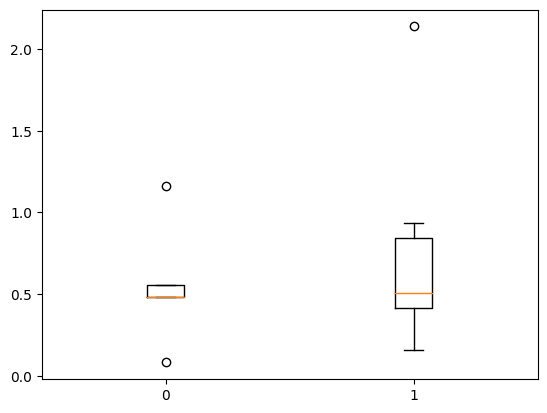

In [ ]:
import matplotlib.pyplot as plt

d = result_df[['gender','loss']]

m = d[d['gender']==M]
f = d[d['gender']==F]

# pd.DataFrame([m,f])

plt.boxplot(m.values[:,1], positions=[0])
plt.boxplot(f.values[:,1], positions=[1])
# plt.scatter(*np.array([[0,i] for i in  m.values[:,1]]).T)
# plt.scatter(*np.array([[1,i] for i in  f.values[:,1]]).T)

In [ ]:
print([[0,i] for i in  m.values[:,1]])

[[0, 0.2522866129875183],
 [0, 0.3936497554183006],
 [0, 0.44422163707869394],
 [0, 0.11601697467267513],
 [0, 0.2904790488156405]]

In [ ]:
# result_df.to_csv('/content/results.csv')

## tests on the 1/2/6/19 set

In [ ]:
# after 100 epochs
one, two, six, nineteen = [test(testloaders[k]) for k in ['chb01', 'chb02', 'chb06', 'chb19']]

# experiment 1: comparing F11 vs M11
print(f"chb01: {one:.4f} | chb02: {two:.4f}")

# experiment 2: comparing F11 vs F1.5 vs F19
print(f"chb01: {one:.4f} | chb06: {six:.4f} | chb19: {nineteen:.4f}")

chb01: 0.2102 | chb02: 0.2776
chb01: 0.2102 | chb06: 1.2321 | chb19: 0.3332


In [ ]:
# after 40 epochs
one, two, six, nineteen = [test(testloaders[k]) for k in ['chb01', 'chb02', 'chb06', 'chb19']]

# experiment 1: comparing F11 vs M11
print(f"chb01: {one:.4f} | chb02: {two:.4f}")

# experiment 2: comparing F11 vs F1.5 vs F19
print(f"chb01: {one:.4f} | chb06: {six:.4f} | chb19: {nineteen:.4f}")

chb01: 0.2142 | chb02: 0.4754
chb01: 0.2142 | chb06: 0.5351 | chb19: 0.2442


# download data

In [ ]:
%cd /content/drive/MyDrive/
!mkdir chbmit
%cd chbmit/

# !wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/chb01/
# !wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/chb02/
# !wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/chb03/
# !wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/chb05/
# !wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/chb07/
# !wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/chb10/

/content/drive/MyDrive
mkdir: cannot create directory ‘chbmit’: File exists
/content/drive/MyDrive/chbmit
--2023-10-28 09:30:31--  https://physionet.org/files/chbmit/1.0.0/chb07/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/chbmit/1.0.0/chb07/index.html’

physionet.org/files     [ <=>                ]   2.88K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2023-10-28 09:30:31 (300 MB/s) - ‘physionet.org/files/chbmit/1.0.0/chb07/index.html’ saved [2948]

Loading robots.txt; please ignore errors.
--2023-10-28 09:30:31--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

--2023-10-28 09:30:31--  https://physionet.org/files/chbm